# Projeto Final de Ciência dos Dados. ( PkmnID)

## Algoritmo de "machine learning", utilizando a ferramenta "RandomForest", para identificar o nome de cada pokemon a partir de suas imagens.

In [1]:
!pip install opencv-contrib-python
import cv2
import os
import os.path
import numpy as np
import math
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from pprint import pprint

# Set random seed
np.random.seed(0)

In [33]:
TRAIN_DIR = 'Assets//Data_Train'
TEST_DIR = 'Assets//Data_Test'

NUM_CLUSTERS = 40

TRAIN_IMG = []
TEST_IMG = []
TRAIN_LABEL = []
TEST_LABEL = []

for train, test in zip(os.listdir(TRAIN_DIR), os.listdir(TEST_DIR)): #Tecnicamente são iguais, mas não custa garantir.
    for img_train, img_test in zip(os.listdir(os.path.join(TRAIN_DIR,train)), os.listdir(os.path.join(TEST_DIR,test))):
        TRAIN_IMG.append(os.path.join(TRAIN_DIR,train,img_train))
        TEST_IMG.append(os.path.join(TEST_DIR,test,img_test))
        TRAIN_LABEL.append(train)
        TEST_LABEL.append(test)


# def get_images_from_category(category, num_train, num_test, data_dir):
#     category_dir = os.path.join(DATA_DIR, category)
#     num_total = num_train + num_test
#     filenames_train = []
#     filenames_test = []
    
#     for k, filename in enumerate(os.listdir(category_dir)):
#         if k < num_train:
#             filenames_train.append(os.path.join(category_dir, filename))
#         elif k < num_total:
#             filenames_test.append(os.path.join(category_dir, filename))
#         else:
#             break
#     return filenames_train, filenames_test

# def get_images_from_category_list(category_list, num_train, num_test, data_dir):
#     filenames_train_all = []
#     target_train = []
#     filenames_test_all = []
#     target_test = []
#     for category in category_list:
#         filenames_train, filenames_test = get_images_from_category(category, num_train, num_test, data_dir)
#         filenames_train_all.extend(filenames_train)
#         target_train.extend([category] * NUM_IMAGES_TRAIN_PER_CATEGORY)
#         filenames_test_all.extend(filenames_test)
#         target_test.extend([category] * NUM_IMAGES_TEST_PER_CATEGORY)
#     return filenames_train_all, filenames_test_all, target_train, target_test

def cria_vocabulario(imagens, num_clusters):
    km = cv2.BOWKMeansTrainer(num_clusters)
    akaze = cv2.KAZE_create()
    for p in imagens:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        mask = np.ones(img.shape)
        kp, desc = akaze.detectAndCompute(img, mask)
        km.add(desc)
    return km.cluster()

def representa(vocab, img):
    kaze = cv2.KAZE_create()
    kp = kaze.detect(img)
    bowdesc = cv2.BOWImgDescriptorExtractor(kaze, cv2.FlannBasedMatcher())
    bowdesc.setVocabulary(vocab)
    return bowdesc.compute(img, kp)

def transforma_imagens(imagens, vocab):
    X = []
    for p in imagens:
        img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        X.append(representa(vocab, img).flatten())
    return np.array(X)



vocab = cria_vocabulario(TRAIN_IMG, NUM_CLUSTERS)
X_train = transforma_imagens(TRAIN_IMG, vocab)
X_test = transforma_imagens(TEST_IMG, vocab)
y_train = TRAIN_LABEL
y_test = TEST_LABEL

# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_jobs=-1, random_state=0, n_estimators = 100)

# Train the Classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train, y_train)
scr = clf.score(X_test, y_test)

Normalized confusion matrix
[[0.59 0.04 0.01 0.09 0.04 0.08 0.01 0.   0.04 0.   0.09 0.01 0.  ]
 [0.24 0.19 0.   0.11 0.09 0.05 0.   0.   0.3  0.03 0.   0.   0.  ]
 [0.11 0.   0.54 0.04 0.   0.   0.11 0.   0.11 0.   0.01 0.03 0.04]
 [0.01 0.01 0.02 0.54 0.08 0.   0.01 0.   0.25 0.02 0.04 0.01 0.  ]
 [0.07 0.05 0.01 0.15 0.45 0.03 0.   0.   0.09 0.   0.14 0.01 0.  ]
 [0.18 0.04 0.02 0.09 0.09 0.29 0.   0.   0.14 0.04 0.12 0.   0.  ]
 [0.   0.   0.1  0.1  0.   0.   0.59 0.   0.18 0.   0.   0.02 0.  ]
 [0.07 0.   0.1  0.1  0.   0.   0.07 0.2  0.35 0.   0.1  0.   0.  ]
 [0.   0.   0.   0.09 0.   0.   0.07 0.   0.69 0.01 0.04 0.06 0.04]
 [0.02 0.05 0.   0.2  0.04 0.05 0.   0.   0.05 0.34 0.07 0.14 0.04]
 [0.11 0.   0.01 0.13 0.   0.   0.07 0.   0.13 0.   0.5  0.03 0.02]
 [0.03 0.   0.05 0.23 0.   0.05 0.05 0.   0.31 0.01 0.   0.23 0.05]
 [0.1  0.   0.08 0.   0.02 0.08 0.04 0.15 0.08 0.   0.   0.   0.46]]


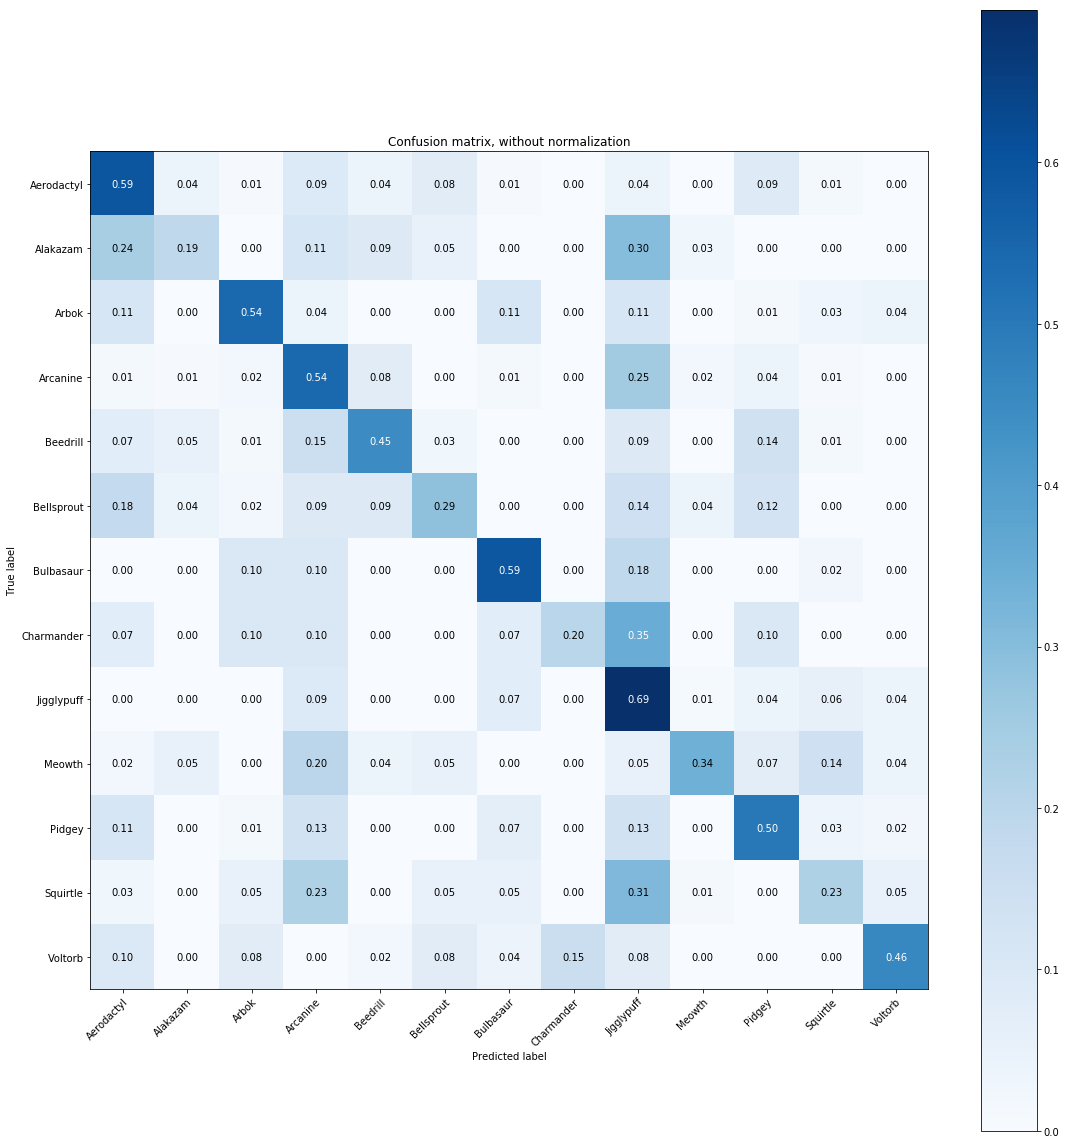

In [34]:
#### Código retirado de https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html


y_pred = clf.predict(X_test)
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize = (16,16))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=clf.classes_,
                      title='Confusion matrix, without normalization')



plt.show()

(array([[0.12, 0.06, 0.  , 0.1 , 0.07, 0.06, 0.04, 0.04, 0.03, 0.04, 0.25,
         0.18, 0.01]]),
 array(['Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Beedrill',
        'Bellsprout', 'Bulbasaur', 'Charmander', 'Jigglypuff', 'Meowth',
        'Pidgey', 'Squirtle', 'Voltorb'], dtype='<U10'))

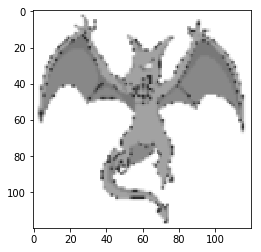

In [35]:
def show_example(path = "Testes/Testes/9.png", Plot = True):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, dsize=(120, 120))
    if Plot:
        plt.imshow(img_resized, cmap='gray', vmin=0, vmax=255)
    return representa(vocab, img_resized)

clf.predict_proba(show_example()), clf.classes_

In [36]:
scr

0.4677121771217712

## Análise Exploratória:

## Para realizar a análise exploratória seguiremos alguns passos:

# Passo 1:
## Extrair histograma:
### O código abaixo Extrai histograma de frequências relativas de features de todas as imagens do Dataset escolhido. (Pokemons)

In [37]:
origin_dir = 'Assets//Data_Filtered_Resized'
Hist_Dict = {}
for pkmn in os.listdir(origin_dir):
    Hist_Dict[pkmn] = []
    current_dir = os.path.join(origin_dir,pkmn)
    for k, img in enumerate(os.listdir(current_dir)):
        Hist_Dict[pkmn].append(show_example(os.path.join(current_dir,img), Plot = False))
# print(Hist_Dict['Alakazam'])

# Passo 2:
## Criar um DataFrame para trabalhar melhor com o DataSet:
### Foi necessário criar um dataframe dedicado a cada pokemon com suas respectivas frequências relativas. Visando melhorar e facilitar a análise permitindo cruzar e manusear os dados com maior facilidade.

In [38]:
lista = []
lista_nomes = os.listdir('Assets/Data_Filtered_Resized')
for k in Hist_Dict:
    x = pd.Series(Hist_Dict[k]).mean()
    x = pd.Series(x[0])
    lista.append(x)
df_medias = pd.DataFrame(lista, index = lista_nomes)

## Tabela das frequências relativas médias de cada feature por pokémon:

In [39]:
df_medias.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Aerodactyl,0.044125,0.022021,0.025219,0.003587,0.030375,0.007808,0.030084,0.021248,0.007485,0.035705,...,0.003215,0.078172,0.003767,0.016552,0.041743,0.025346,0.040101,0.078002,0.009231,0.006980
Alakazam,0.043118,0.036006,0.038627,0.004763,0.039061,0.006012,0.045784,0.042670,0.006036,0.039553,...,0.005334,0.036470,0.006837,0.012137,0.035224,0.013674,0.023483,0.050601,0.009484,0.008814
Arbok,0.026397,0.027637,0.028123,0.013263,0.031611,0.017638,0.027310,0.017533,0.024831,0.015485,...,0.007848,0.024977,0.013161,0.093739,0.014520,0.042971,0.007385,0.037678,0.014690,0.014757
Arcanine,0.042683,0.040201,0.048822,0.004869,0.043375,0.006344,0.045582,0.051821,0.008915,0.020941,...,0.005868,0.012394,0.012381,0.029230,0.041230,0.037931,0.016285,0.014535,0.010258,0.005271
Beedrill,0.049104,0.027953,0.044069,0.004035,0.037597,0.005056,0.036884,0.037701,0.005793,0.030814,...,0.002466,0.039709,0.007379,0.017522,0.058210,0.021630,0.023562,0.040876,0.011840,0.004400


# Passo 3:
## Calculando o valor médio dos dados:
### Nesta etapa foi necessário tirar o valor médio dos dados. Para assim aproxima-los do ponto (0,0), origem do sistema. Dessa forma permitindo a distinção evidente entre cada um deles.

In [40]:
df_medias = df_medias - (1/40) 

In [41]:
df_medias.sum(axis=1)

Aerodactyl    2.421439e-08
Alakazam     -1.862645e-08
Arbok         8.940697e-08
Arcanine      0.000000e+00
Beedrill     -1.490116e-07
Bellsprout   -1.490116e-08
Bulbasaur     4.470348e-08
Charmander   -4.470348e-08
Jigglypuff    1.490116e-08
Meowth       -1.490116e-08
Pidgey        5.960464e-08
Squirtle     -1.490116e-08
Voltorb       2.235174e-08
dtype: float32

In [42]:
normas = (df_medias*df_medias).sum(axis=1)
for m in normas.index:
    df_medias.loc[m] = df_medias.loc[m]/np.sqrt(normas[m])

# Passo 4:
## Facilitando a comparação entre os pokemons:
### Tabela que mostra o quanto os pokémons são semelhantes entre si, diagonal principal é 1, pois todo pokémon é idêntico a si mesmo.

In [10]:
df_compara = df_medias.dot(df_medias.transpose())
df_compara

,Aerodactyl,Alakazam,Arbok,Arcanine,Beedrill,Bellsprout,Bulbasaur,Charmander,Jigglypuff,Meowth,Pidgey,Squirtle,Voltorb
Aerodactyl,1.000000,0.720088,0.175681,0.373578,0.696574,0.403766,0.003720,0.549734,0.126439,0.523185,0.503007,0.302069,0.265671
Alakazam,0.720088,1.000000,0.258615,0.743704,0.868299,0.658054,0.188466,0.504001,0.456721,0.857561,0.575028,0.584170,-0.028053
Arbok,0.175681,0.258615,1.000000,0.468103,0.239427,0.174650,0.574482,0.376063,0.157784,0.167515,0.243170,0.515625,0.654538
Arcanine,0.373578,0.743704,0.468103,1.000000,0.803692,0.755153,0.525280,0.684684,0.722602,0.804898,0.795379,0.893194,0.061331
Beedrill,0.696574,0.868299,0.239427,0.803692,1.000000,0.749389,0.257468,0.633529,0.579668,0.842386,0.766592,0.645056,0.089673
Bellsprout,0.403766,0.658054,0.174650,0.755153,0.749389,1.000000,0.181775,0.560937,0.674384,0.778625,0.750725,0.665148,-0.008447
Bulbasaur,0.003720,0.188466,0.574482,0.525280,0.257468,0.181775,1.000000,0.594129,0.521647,0.326911,0.441172,0.694687,0.410105
Charmander,0.549734,0.504001,0.376063,0.684684,0.633529,0.560937,0.594129,1.000000,0.597539,0.617762,0.858095,0.819010,0.396873
Jigglypuff,0.126439,0.456721,0.157784,0.722602,0.579668,0.674384,0.521647,0.597539,1.000000,0.700520,0.688029,0.721730,0.084692
Meowth,0.523185,0.857561,0.167515,0.804898,0.842386,0.778625,0.326911,0.617762,0.700520,1.000000,0.754423,0.725103,-0.052270


### Aqui, podemos observar que alguns pokémons tem semelhanças muito fortes entre si, pois apresentam as mesmas features em abundância (na média).

In [11]:
monstros = []
for feat in range(NUM_CLUSTERS):
    monstros.append(sorted(df_medias.nlargest(n=5, columns=[feat]).index) + [feat])
x = sorted(monstros)
pprint(x)

[['Aerodactyl', 'Alakazam', 'Arbok', 'Arcanine', 'Meowth', 0],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Bulbasaur', 'Meowth', 8],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Charmander', 'Voltorb', 6],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Charmander', 'Voltorb', 26],
 ['Aerodactyl', 'Alakazam', 'Beedrill', 'Meowth', 'Voltorb', 35],
 ['Aerodactyl', 'Alakazam', 'Bulbasaur', 'Charmander', 'Meowth', 9],
 ['Aerodactyl', 'Arbok', 'Bellsprout', 'Jigglypuff', 'Voltorb', 30],
 ['Aerodactyl', 'Arbok', 'Bulbasaur', 'Jigglypuff', 'Voltorb', 16],
 ['Aerodactyl', 'Arbok', 'Bulbasaur', 'Jigglypuff', 'Voltorb', 25],
 ['Aerodactyl', 'Arcanine', 'Charmander', 'Meowth', 'Pidgey', 29],
 ['Aerodactyl', 'Beedrill', 'Charmander', 'Pidgey', 'Voltorb', 28],
 ['Aerodactyl', 'Charmander', 'Jigglypuff', 'Squirtle', 'Voltorb', 14],
 ['Alakazam', 'Arbok', 'Arcanine', 'Beedrill', 'Bulbasaur', 7],
 ['Alakazam', 'Arbok', 'Bellsprout', 'Bulbasaur', 'Voltorb', 2],
 ['Alakazam', 'Arbok', 'Bellsprout', 'Jigglypuff', 'Vol

In [12]:
df_compara.sum(axis = 1).sort_values(ascending = False)

Arcanine      8.631598
Squirtle      8.622605
Pidgey        8.416170
Charmander    8.192355
Beedrill      8.171754
Meowth        8.046619
Alakazam      7.386654
Bellsprout    7.344159
Jigglypuff    7.031756
Bulbasaur     5.719843
Aerodactyl    5.643513
Arbok         5.005655
Voltorb       3.306407
dtype: float32

In [13]:
scr, 1/13

(0.4603321033210332, 0.07692307692307693)

## Bibliografia:
- Modelo Bag of Visual Words, e parte da análise exploratória produzidos por/com assistência de Fábio Ayres.
- Dataset: [Pokémon Gen One](https://www.kaggle.com/thedagger/pokemon-generation-one/data) da plataforma Kaggle.com
